## Analysis of the Results of the Quantum optimal control

Imports

In [2]:
from collections import Counter
from src.hamiltonian_utils import FermiHubbardHamiltonian
from src.nuclear_physics_utils import get_twobody_nuclearshell_model,SingleParticleState,QuadrupoleOperator,J2operator,write_j_square_twobody_file
import numpy as np
import torch
from typing import Dict
from src.qml_models import AdaptVQEFermiHubbard
from src.qml_utils.train import Fit
from src.qml_utils.utils import configuration
from scipy.sparse.linalg import eigsh,expm_multiply
from tqdm import trange
import matplotlib.pyplot as plt
import scipy
from typing import List,Type
from scipy.optimize import minimize,dual_annealing
from tqdm import trange
from src.qml_utils.utils import Schedule,SchedulerModel
from scipy.sparse import csr_matrix, diags
from numpy.linalg import eigh

In [3]:
nlevels=3

tf=5
nsteps=50
number_of_parameters=20

file_name:str='data/cki'
qq_filename:str='data/qq.p'
pairing_filename:str='data/pair_inter.p'

j_square_filename:str=file_name+'_j2'
SPS=SingleParticleState(file_name=file_name)
energies:List=SPS.energies


nparticles_a:int=2
nparticles_b:int=2

size_a:int=SPS.energies.shape[0]//2
size_b:int=SPS.energies.shape[0]//2
title=r'$^{8}$Be'

Target Hamiltonian

In [4]:
# Target Hamiltonian
TargetHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,symmetries=[SPS.total_M_zero])
if file_name=='data/cki':
    twobody_matrix,energies=get_twobody_nuclearshell_model(file_name=file_name)
    TargetHamiltonian.get_twobody_interaction(twobody_dict=twobody_matrix)
else:
    TargetHamiltonian.twobody_operator=scipy.sparse.load_npz(f'data/nuclear_twobody_matrix/usdb_{nparticles_a}_{nparticles_b}.npz')
print('size=',size_a+size_b,size_b)
TargetHamiltonian.get_external_potential(external_potential=energies[:size_a+size_b])

TargetHamiltonian.get_hamiltonian()

egs,psis=TargetHamiltonian.get_spectrum(n_states=nlevels)
print('Hamiltonian shape=',TargetHamiltonian.hamiltonian.shape)
egs=egs[0]
print(egs)
psi0=psis[:,:1]

Computing the matrix, pls wait... (u_u) 



  0%|          | 0/12 [00:00<?, ?it/s]

100%|██████████| 12/12 [00:02<00:00,  5.68it/s]
1424it [00:01, 725.29it/s]


size= 12 6
Hamiltonian shape= (51, 51)
-30.295394613605513


PP and QQ interactions

In [5]:
matrix_qq,_=get_twobody_nuclearshell_model(file_name=qq_filename)



QQoperator=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,symmetries=[SPS.total_M_zero])
QQoperator.get_twobody_interaction(twobody_dict=matrix_qq)
QQoperator.get_hamiltonian()


#effective QQ operator
local_qq_matrix={}
for key,value in matrix_qq.items():
    a,b,c,d=key
    
    n,l,ja,m,t,tz_a=SPS.state_encoding[a]
    n,l,jb,m,t,tz_b=SPS.state_encoding[b]
    n,l,jc,m,t,tz_c=SPS.state_encoding[c]
    n,l,jd,m,t,tz_d=SPS.state_encoding[d]
    if ja==jb and jb==jc and jc==jd:
        local_qq_matrix[(a,b,c,d)]=value


LocalQQoperator=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,symmetries=[SPS.total_M_zero])
LocalQQoperator.get_twobody_interaction(twobody_dict=local_qq_matrix)
LocalQQoperator.get_hamiltonian()

matrix_pairing,_=get_twobody_nuclearshell_model(file_name=pairing_filename)
PPoperator=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,symmetries=[SPS.total_M_zero])
PPoperator.get_twobody_interaction(twobody_dict=matrix_pairing)
PPoperator.get_hamiltonian()
mean_field_hamiltonian=diags(TargetHamiltonian.hamiltonian.diagonal(), format='csr')


Computing the matrix, pls wait... (u_u) 



100%|██████████| 12/12 [00:02<00:00,  5.89it/s]
1256it [00:01, 708.15it/s]
232it [00:00, 700.10it/s]


Computing the matrix, pls wait... (u_u) 



100%|██████████| 12/12 [00:01<00:00,  9.49it/s]
216it [00:00, 730.42it/s]


Initial Hamiltonian

In [6]:
#### Initial Hamiltonian
min_b=np.zeros(size_a+size_b)

if file_name=='data/cki':
    order_of_filling=np.asarray([0,3,1,2,4,5])
    order_of_filling_protons=order_of_filling+size_a
else:
    order_of_filling=np.asarray([0,5,1,4,2,3,6,7,8,11,9,10])
    order_of_filling_protons=order_of_filling+size_a


min_b[order_of_filling[:nparticles_a]]=1
min_b[order_of_filling_protons[:nparticles_b]]=1




print('initial state=',min_b)
InitialHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,symmetries=[SPS.total_M_zero])
kinetic_term:Dict={}
adj_matrix=np.zeros((size_a+size_b,size_a+size_b))
idx=InitialHamiltonian._get_index(element=min_b)
print('idx=',idx)
psi_configuration=np.zeros(TargetHamiltonian.hamiltonian.shape[0])
psi_configuration[idx]=1
min=psi_configuration.transpose().dot(TargetHamiltonian.hamiltonian.dot(psi_configuration))      
external_field=np.zeros(size_a+size_b)
external_field=-1*(np.abs(min)/(nparticles_a+nparticles_b))*min_b
print('min energy=',min)
InitialHamiltonian.get_external_potential(external_field)
InitialHamiltonian.get_hamiltonian()


initial state= [1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0.]
idx= 5
min energy= -15.405709999999996


Loading the data

(-37.60481476565048-7.105427357601002e-15j)


/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


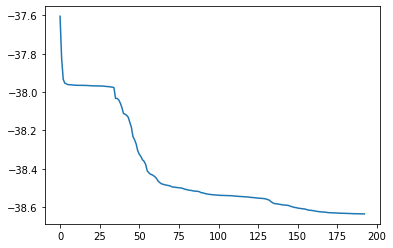

In [8]:
data=np.load('data/optimal_control_results/20ne_optimal_control.npz',allow_pickle=True)
info=data['info']

energy=data['history']
history_drivings=data['history_drivings']
psis=data['history_psi']
print(energy[0])
plt.plot(np.arange(len(energy)),energy)
plt.show()

Superposition with respect to the exact ground state

In [13]:
drivings=history_drivings[-1]
hd,ht1,ht2=drivings
print(psis[-1].shape)
simpler_target_hamiltonian=QQoperator.hamiltonian*ht2[-1]+(PPoperator.hamiltonian+mean_field_hamiltonian)*ht1[-1]

(640,)


In [10]:

eigenvalues,eigenstates=eigh(simpler_target_hamiltonian.todense())


[-3.93780438e+01 -3.30557773e+01 -2.86720733e+01 -2.79813648e+01
 -2.69396509e+01 -2.54175807e+01 -2.51429345e+01 -2.50121738e+01
 -2.45132492e+01 -2.43076280e+01 -2.40706868e+01 -2.37628652e+01
 -2.36599204e+01 -2.34782917e+01 -2.31034455e+01 -2.25101416e+01
 -2.23480789e+01 -2.23103020e+01 -2.17937981e+01 -2.17279023e+01
 -2.15785316e+01 -2.13279749e+01 -2.12944358e+01 -2.07201037e+01
 -2.03289920e+01 -2.02538417e+01 -1.99972308e+01 -1.98209249e+01
 -1.93913244e+01 -1.90894733e+01 -1.90885833e+01 -1.88373858e+01
 -1.87367502e+01 -1.85462162e+01 -1.81692105e+01 -1.81423082e+01
 -1.81414284e+01 -1.77414801e+01 -1.76431946e+01 -1.73837772e+01
 -1.73617355e+01 -1.68266745e+01 -1.64747439e+01 -1.64573727e+01
 -1.63330312e+01 -1.60414478e+01 -1.59117707e+01 -1.58430525e+01
 -1.58421812e+01 -1.54948855e+01 -1.54549154e+01 -1.54343169e+01
 -1.51903755e+01 -1.47066764e+01 -1.47047300e+01 -1.46865551e+01
 -1.45006963e+01 -1.44800810e+01 -1.44569899e+01 -1.44408789e+01
 -1.44264751e+01 -1.43900

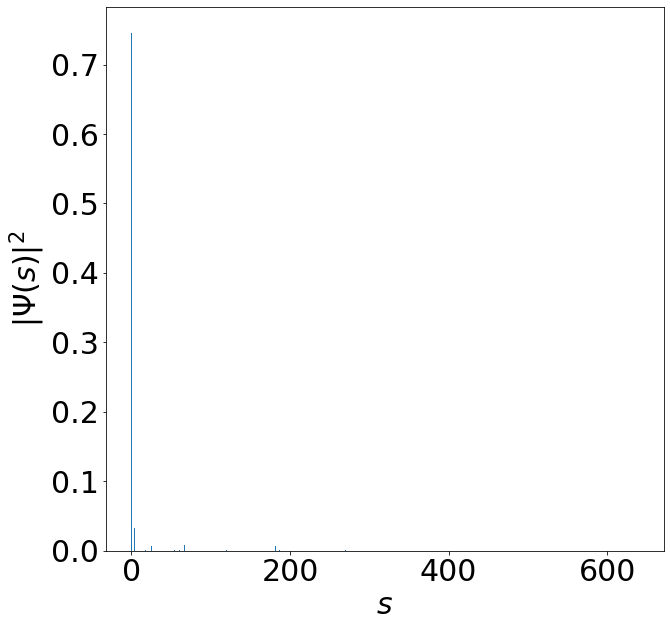

(640, 1)
(0.8047581274864015+0j)


/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


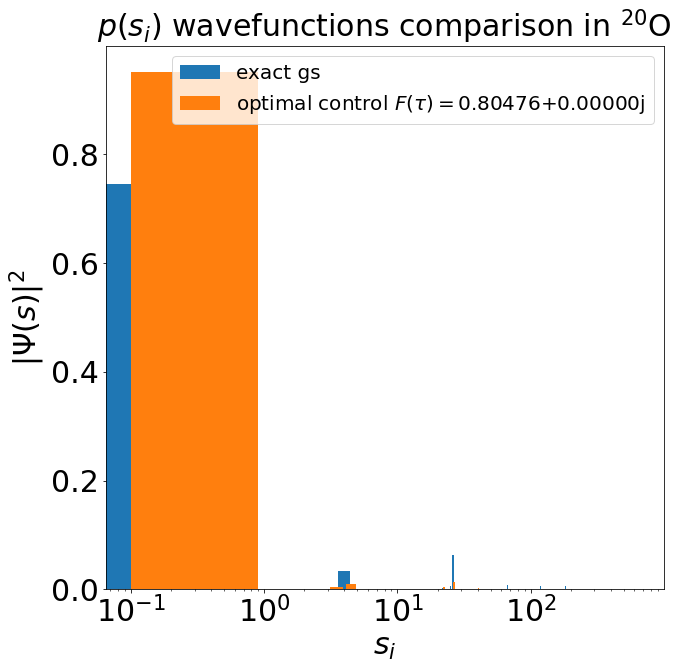

(0.8047581274864015+0j)


In [16]:
overlap=np.einsum('i,ia->a',psi0[:,0].conjugate(),eigenstates)*np.conjugate(np.einsum('i,ia->a',psi0[:,0].conjugate(),eigenstates))
print(eigenvalues)
plt.figure(figsize=(10,10))
plt.bar(np.arange(overlap.shape[0]),overlap)
plt.xlabel(r'$s$',fontsize=30)
plt.ylabel(r'$|\Psi(s)|^2$',fontsize=30)
plt.tick_params(labelsize=30)
plt.show()
overlap_optimization=np.einsum('i,ia->a',psis[-1].conjugate(),eigenstates)*np.conjugate(np.einsum('i,ia->a',psis[-1].conjugate(),eigenstates))
print(psi0.shape)
print((psi0[:,0].conjugate().dot(psis[-1]))*np.conjugate((psi0[:,0].conjugate().dot(psis[-1]))))
plt.figure(figsize=(10,10))
plt.title(r'$p(s_i)$ wavefunctions comparison in '+title,fontsize=30)
plt.bar(np.arange(overlap.shape[0]),overlap,label='exact gs')
plt.bar(np.arange(overlap.shape[0])+0.5,overlap_optimization,label=r'optimal control $F(\tau)=$'+f'{(psi0[:,0].conjugate().dot(psis[-1]))*np.conjugate((psi0[:,0].conjugate().dot(psis[-1]))):.5f}')
plt.xlabel(r'$s_i$',fontsize=30)
plt.ylabel(r'$|\Psi(s)|^2$',fontsize=30)
plt.tick_params(labelsize=30)
plt.legend(fontsize=20)
plt.semilogx()
plt.show()
print((psi0[:,0].conjugate().dot(psis[-1]))*np.conjugate((psi0[:,0].conjugate().dot(psis[-1]))))